# Análise explorátoria dos dados de treino/teste

##  Importação de bibliotecas e dados

In [20]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_notarget.parquet'  ,'/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df = pd.read_parquet('./datasets/df_train_test.parquet', engine='pyarrow')
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,Debit (Prepaid),5497590243197280,07/2022,306,YES,2,55.0,05/2008,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,Credit,5175842699412235,12/2024,438,YES,1,9100.0,09/2005,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,Debit,5874992802287595,05/2020,256,YES,1,14802.0,01/2006,2008,No
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,Debit,4354185735186651,01/2020,120,YES,1,19113.0,07/2009,2014,No
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,Debit (Prepaid),5207231566469664,03/2014,198,YES,1,89.0,01/2008,2015,No


## Ajuste no tipo de dado

In [11]:
df['target'].value_counts()

,count
target,
No,7394705
Yes,10665


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405370 entries, 0 to 7405369
Data columns (total 38 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   date                   datetime64[ns]
 2   client_id              int64         
 3   card_id                int64         
 4   amount                 float64       
 5   use_chip               object        
 6   merchant_id            int64         
 7   merchant_city          object        
 8   merchant_state         object        
 9   zip                    float64       
 10  mcc                    object        
 11  errors                 object        
 12  description            object        
 13  target                 object        
 14  current_age            int64         
 15  retirement_age         int64         
 16  birth_year             int64         
 17  birth_month            int64         
 18  gender                

In [16]:
df['id'] = df['id'].astype(str)
df['client_id'] = df['client_id'].astype(str)
df['card_id'] = df['card_id'].astype(str)
df['merchant_id'] = df['merchant_id'].astype(str)
df['zip'] = df['zip'].astype(str)
df['card_number'] = df['card_number'].astype(str)
df['cvv'] = df['cvv'].astype(str)

## Análise dos dados

In [100]:
df_time = pd.DataFrame()
df_time['year'] = df['date'].dt.to_period('Y')
df_time['year_month'] = df['date'].dt.to_period('M')
df_time['target'] = df['target']
df_time.head()

,year,year_month,target
0,2010,2010-01,No
1,2010,2010-01,No
2,2010,2010-01,No
3,2010,2010-01,No
4,2010,2010-01,No


In [101]:
df_time = pd.pivot_table(df_time, index='year', columns='target', aggfunc='count').reset_index()
df_time.columns = ['year', 'target_no', 'target_yes']
df_time['total'] = df_time['target_no'] + df_time['target_yes']
df_time['percent_no'] = df_time['target_no'] / df_time['total']
df_time['percent_yes'] = df_time['target_yes'] / df_time['total']
df_time

,year,target_no,target_yes,total,percent_no,percent_yes
0,2010,828956,2573,831529,0.996906,0.003094
1,2011,863391,37,863428,0.999957,0.000043
2,2012,884498,923,885421,0.998958,0.001042
3,2013,905967,1337,907304,0.998526,0.001474
4,2014,914409,664,915073,0.999274,0.000726
5,2015,928035,2189,930224,0.997647,0.002353
6,2016,930314,2448,932762,0.997376,0.002624
7,2017,937112,172,937284,0.999816,0.000184
8,2018,202023,322,202345,0.998409,0.001591


In [108]:
sns.lineplot?

TypeError: Invalid object type at position 0

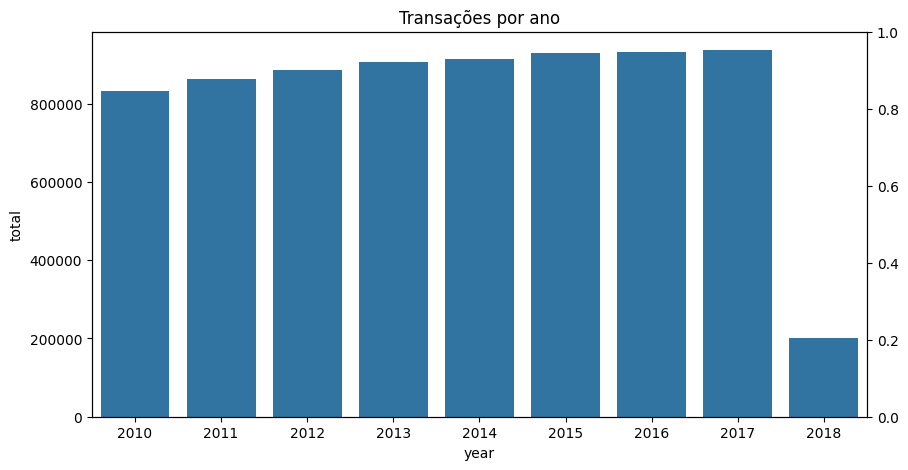

In [110]:
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.title('Transações por ano')
sns.barplot(df_time, x='year', y='total', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(df_time, x='year', y='percent_yes', ax=ax2)
ax2.set_ylabel('Fraudes')

ax1.set_zorder(2)
ax1.patch.set_visible(False)
plt.show()

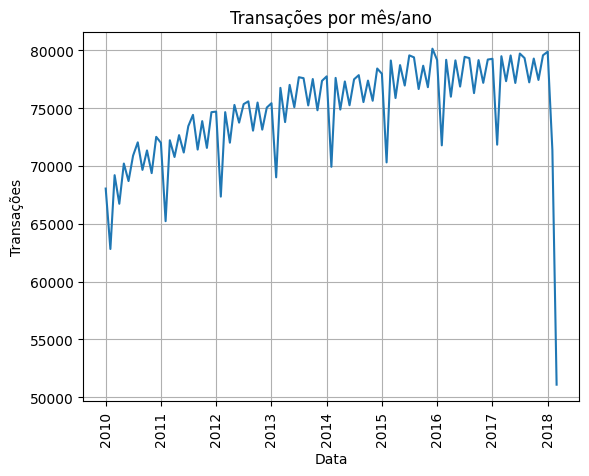

In [70]:
plt.title('Transações por mês/ano')
sns.lineplot(df['year_month'].value_counts().reset_index().sort_values('year_month', ascending=False).reset_index(drop=True), x='year_month', y='count')
plt.xlabel('Data')
plt.ylabel('Transações')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()